In [1]:
# Importing necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from dataset import Dataset

In [2]:
data = Dataset('8h')
data = data.preprocess()

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x =

In [3]:
# df = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv", sep = ',')
data.drop(columns=['Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

In [4]:
# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])
categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])

scaler = StandardScaler()
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
scaled_numerical = scaler.fit_transform(data)
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns = data.columns)
X_combined = pd.concat([scaled_numerical_df, categorical_data], axis=1)


y = X_combined['Energy'] 
X_combined.drop(columns = 'Energy', inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.001,  # Small learning rate to avoid overfitting
    'max_depth': 5,         # Controls the complexity of the model (higher values may overfit)
    'n_estimators': 10000,    # Number of boosting rounds (you can tune this)
    'early_stopping_rounds': 50,  # Stop if there's no improvement after 50 rounds
    'alpha' : 0.1,
    'lambda' : 0.1,
}
# Use a validation set to avoid overfitting
evals = [(train_data, 'train'), (test_data, 'eval')]

# Train the XGBoost model
model = xgb.train(params, train_data, num_boost_round=10000, evals=evals, early_stopping_rounds=50, verbose_eval=100)
y_pred = model.predict(test_data)
# Calculate metrics

6299.818286496303
9193.870000001043
140.12849999964237
[0]	train-rmse:0.97383	eval-rmse:1.09826


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722516643542/work/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.88644	eval-rmse:1.03231
[200]	train-rmse:0.80763	eval-rmse:0.97489
[300]	train-rmse:0.73656	eval-rmse:0.92610
[400]	train-rmse:0.67230	eval-rmse:0.88472
[500]	train-rmse:0.61432	eval-rmse:0.85094
[600]	train-rmse:0.56188	eval-rmse:0.82306
[700]	train-rmse:0.51433	eval-rmse:0.79776
[800]	train-rmse:0.47139	eval-rmse:0.77683
[900]	train-rmse:0.43243	eval-rmse:0.75484
[1000]	train-rmse:0.39718	eval-rmse:0.73421
[1100]	train-rmse:0.36535	eval-rmse:0.71557
[1200]	train-rmse:0.33676	eval-rmse:0.70074
[1300]	train-rmse:0.31066	eval-rmse:0.69012
[1400]	train-rmse:0.28692	eval-rmse:0.68077
[1500]	train-rmse:0.26538	eval-rmse:0.67335
[1600]	train-rmse:0.24617	eval-rmse:0.66667
[1700]	train-rmse:0.22889	eval-rmse:0.66114
[1800]	train-rmse:0.21268	eval-rmse:0.65596
[1900]	train-rmse:0.19787	eval-rmse:0.65136
[2000]	train-rmse:0.18455	eval-rmse:0.64783
[2100]	train-rmse:0.17261	eval-rmse:0.64514
[2200]	train-rmse:0.16174	eval-rmse:0.64259
[2300]	train-rmse:0.15200	eval-rmse:0.640

# XGBoost

In [5]:
# descale
test_data_len = test_data.get_data()
zeros = np.zeros((test_data_len.shape[0], 35))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_pred[i]

predictions = scaler.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((test_data_len.shape[0],35))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_test.iloc[i]
    
original = scaler.inverse_transform(zeros)
original = [i[0] for i in original]

mae = mean_absolute_error(original, predictions)
rmse = np.sqrt(mean_squared_error(original, predictions))
r2 = r2_score(original, predictions)
n = len(original)
p = test_data_len.shape[1]
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))
adjusted_r2_value = adjusted_r2(r2, n, p)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")

Mean Absolute Error (MAE): 1052.725965371617
Root Mean Squared Error (RMSE): 1700.8149377595234
R² Score: 0.6504993090104138
Adjusted R² Score: 1.0655313795605474


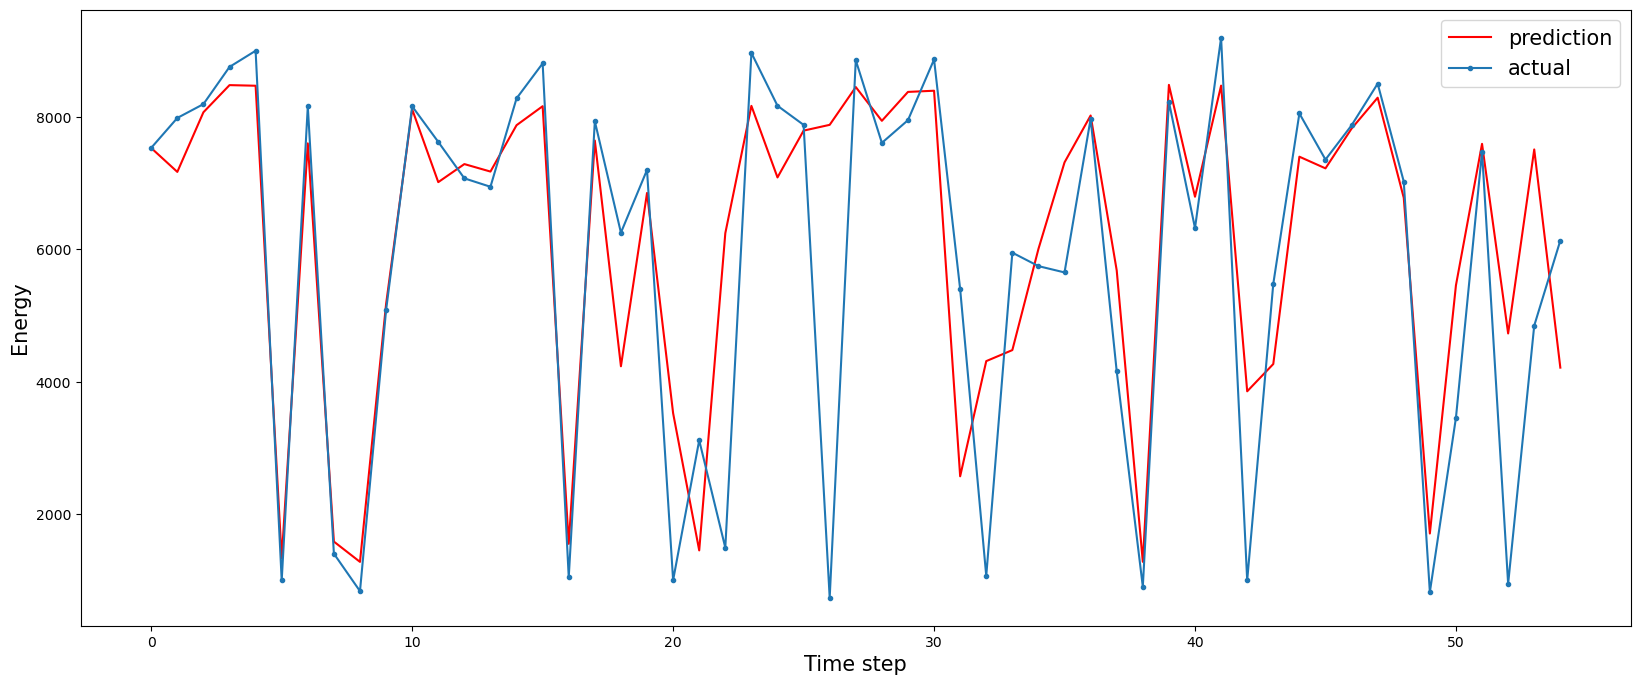

In [10]:
plt.figure(figsize=(20,8))
plt.plot(predictions[:50], label='prediction', color="r")
plt.plot(original[:50], label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

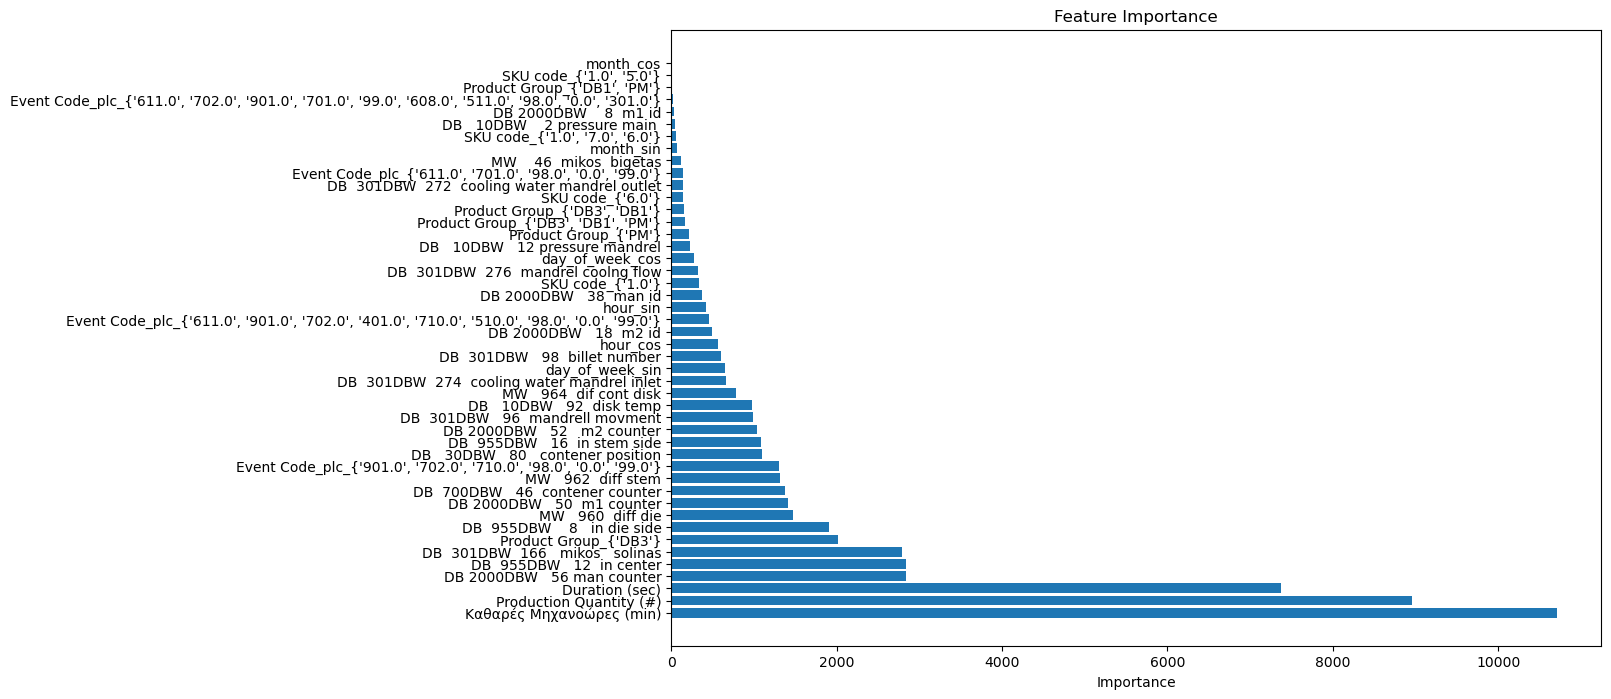

In [7]:
# Assuming 'model' is your trained XGBoost model
# Get feature importances
importance = model.get_score(importance_type='weight')

# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<Figure size 1200x800 with 0 Axes>

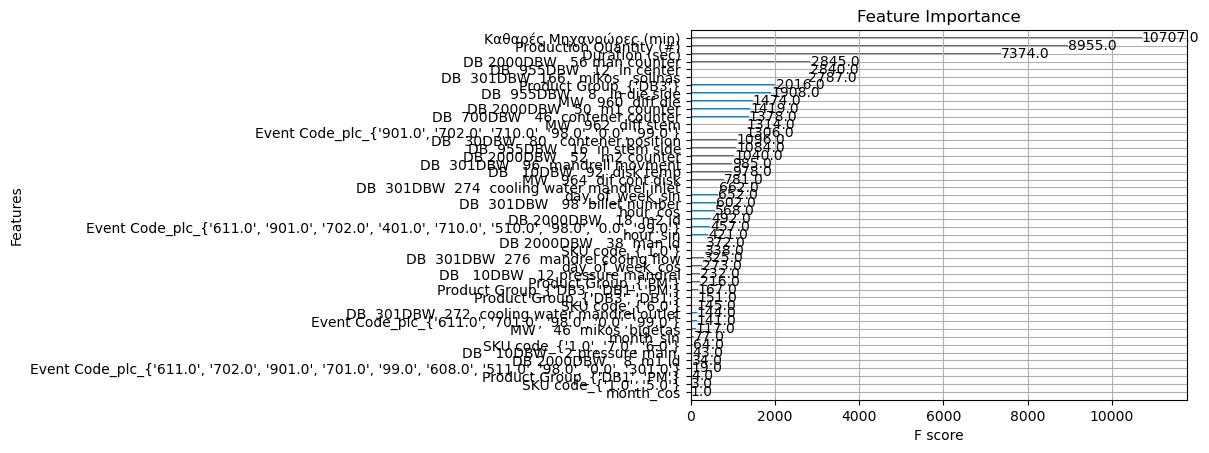

In [8]:
# Plot feature importance
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.title('Feature Importance')
plt.show()


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


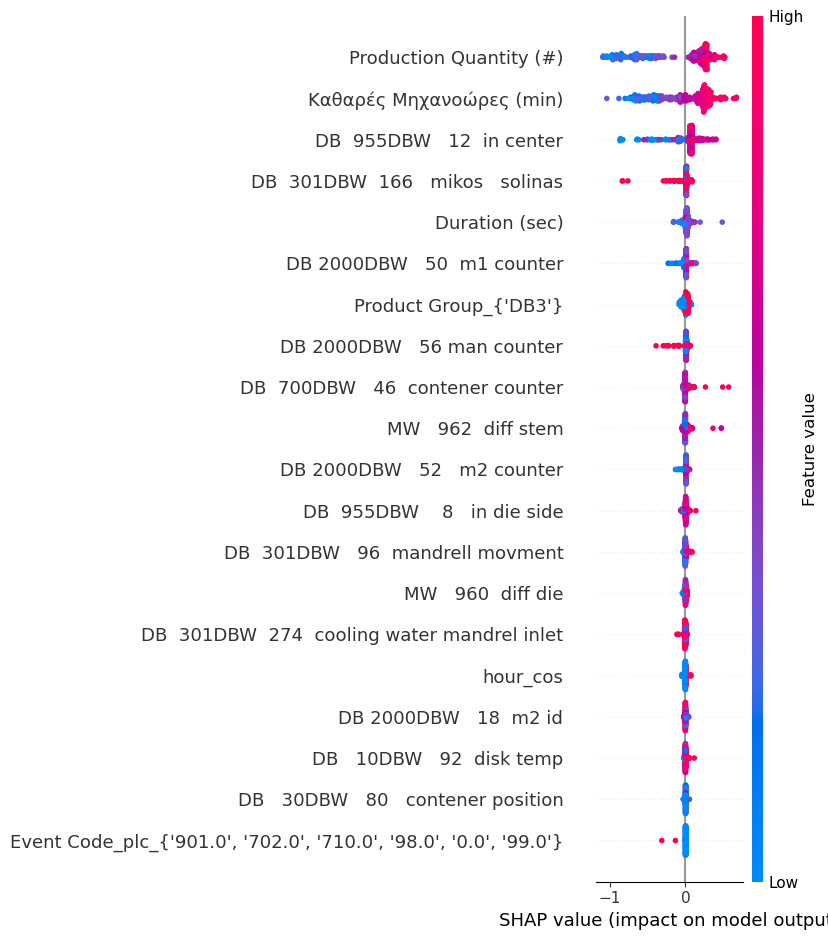

In [9]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_combined)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_combined)